In [6]:
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

class WindyGridworld():
    def __init__(self, is_eight_action = False, ninth_action = False):
        self.xlimit = 10
        self.ylimit = 7
        self.is_eight_action = is_eight_action
        self.ninth_action = ninth_action
        self.wind_dict = { 1: 0, 2: 0, 3: 0, 4: 1, 5: 1,
                           6: 1, 7: 2, 8: 2, 9: 1, 10: 0 }
    def step(self, pos, action):
        x, y = pos
        wind = self.wind_dict[x]
        if action == 'left':
            next_state = max(1, x-1), min(y+wind, self.ylimit)
        elif action == 'right':
            next_state = min(self.xlimit, x+1), min(y+wind, self.ylimit)
        elif action == 'up':
            next_state = x, min(y+wind+1, self.ylimit)
        elif action == 'down':
            next_state = x, max(0, min(y+wind-1, self.ylimit))
        else:
            if self.is_eight_action:
                if action == 'left-up':
                    next_state = max(1, x-1), min(y+wind+1, self.ylimit)
                elif action == 'left-down':
                    next_state = max(1, x-1), max(0,min(y+wind-1, self.ylimit))
                elif action == 'right-up':
                    next_state = min(self.xlimit, x+1), min(y+wind+1, self.ylimit)
                elif action == 'right-down':
                    next_state = min(self.xlimit, x+1), max(0,min(y+wind-1, self.ylimit))
                else:
                    if self.ninth_action:
                        if action == 'stay':
                            next_state = x, max(0,min(y+wind, self.ylimit))
                        else:
                            raise ValueError
                    else:
                        raise ValueError
            else:
                raise ValueError
        if next_state == (8, 4):
            return next_state, 0
        else:
            return next_state, -1

class Agent():
    def __init__(self, alpha=0.5, gamma=1, eps=0.1, is_eight_action = False, ninth_action = False):
        self.alpha = alpha
        self.gamma = gamma
        self.eps = eps
        self.Q = defaultdict(int)
        if not is_eight_action:
            self.action_space= ['left', 'right', 'up', 'down']
        else:
            if ninth_action:
                self.action_space= ['left', 'right', 'up', 'down',
                                'left-up', 'left-down', 'right-up', 'right-down', 'stay']
            else:
                self.action_space= ['left', 'right', 'up', 'down',
                                'left-up', 'left-down', 'right-up', 'right-down']
    def greedy(self, state):
        max_action = self.action_space[0]
        max_Q = self.Q[state, max_action]
        for action in self.action_space:
            if self.Q[state, action] > max_Q:
                max_action = action
                max_Q = self.Q[state, action]
        return max_action

    def e_greedy(self, state):
        if np.random.random() > self.eps:
            return self.greedy(state)
        else:
            random_action = np.random.choice(self.action_space)
            return random_action

    def update(self, R, state, action, next_state, next_action):
        if R == 0:
            next_Q = 0
        else:
            next_Q = self.Q[next_state, next_action]
        self.Q[state, action] += self.alpha * ( R + self.gamma*next_Q - self.Q[state,action] )

def game(is_eight_action = False, ninth_action = False):
    env = WindyGridworld(is_eight_action = is_eight_action, ninth_action = ninth_action)
    EPISODE = 500
    hist = []
    agent = Agent(is_eight_action = is_eight_action, ninth_action = ninth_action)
    for episode in range(EPISODE):
        state = 1,4
        action = agent.e_greedy(state)
        for step in range(5000):
            next_state, R = env.step(state, action)
            next_action = agent.e_greedy(next_state)
            agent.update(R, state, action, next_state, next_action)
            state = next_state
            action = next_action
            if R == 0:
                break
        
        # turn off e-greedy to test
        state = 1, 4
        action = agent.greedy(state)
        for step in range(5000):
            next_state, R = env.step(state, action)
            next_action = agent.greedy(next_state)
            agent.update(R, state, action, next_state, next_action)
            state = next_state
            action = next_action
            if R == 0:
                hist.append(step)
                # means next state is terminal
                break
    return hist



In [7]:
hist_4 = []
hist_8 = []
hist_9 = []
for experiment in range(500):
    hist_4.append(game(is_eight_action = False, ninth_action = False))
    hist_8.append(game(is_eight_action = True, ninth_action = False))
    hist_9.append(game(is_eight_action = True, ninth_action = True))
hist_4 = np.mean(hist_4, axis = 0)
hist_8 = np.mean(hist_8, axis = 0)
hist_9 = np.mean(hist_9, axis = 0)

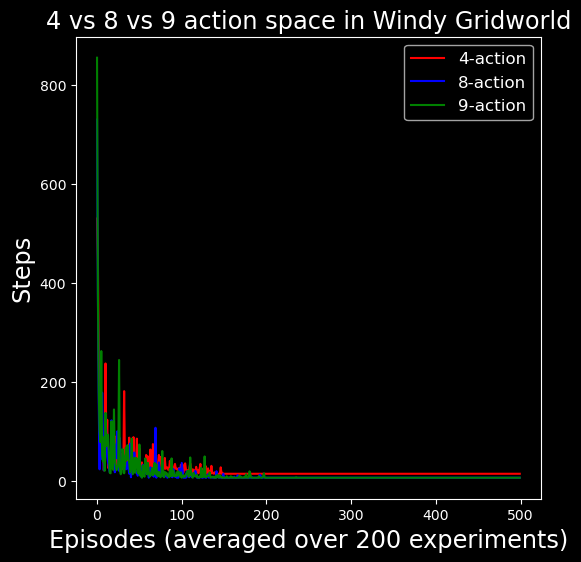

In [8]:
plt.style.use('dark_background')
plt.figure(figsize=(6, 6))
plt.title('4 vs 8 vs 9 action space in Windy Gridworld', fontsize = 'xx-large')
plt.xlabel('Episodes (averaged over 200 experiments)', fontsize = 'xx-large')
plt.ylabel('Steps',fontsize = 'xx-large')
plt.plot(hist_4, '-', c = 'red', label = '4-action')
plt.plot(hist_8, '-', c = 'blue', label = '8-action')
plt.plot(hist_9, '-', c = 'green', label = '9-action')
plt.legend(loc = 'best', prop = {'size':12})
plt.show()